In [1]:
import numpy as np
from matplotlib import pyplot as plt
import wave
import scipy.fftpack

Следующая функция читает из ``wav.``-файла и возвращает два ``numpy`` массива, соответствующих левому и правому каналу:

In [9]:
def read(filename, size=-1):
    fr = wave.open(filename, "rb")
    if size == -1:
        size = fr.getnframes()
    arr = np.array(list(fr.readframes(size)))
    arr = arr.reshape((arr.shape[0] // 4, 4))
    left = arr[:, 0] + ((arr[:, 1] - 128) % 256) * 256 - 32768
    right = arr[:, 2] + ((arr[:, 3] - 128) % 256) * 256 - 32768
    return left, right

In [3]:
fr = wave.open("sample.wav", "rb")
arr = np.array(list(fr.readframes(fr.getnframes())))

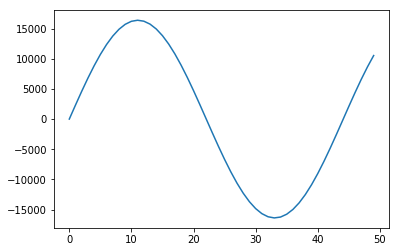

In [226]:
left, right = read("sample.wav")
plt.plot(left[:50])

Эта функция, наоборот, пишет два канала в файл:

In [10]:
def write(filename, left, right):
    fw = wave.open(filename, "wb")
    fw.setnchannels(2)
    fw.setsampwidth(2)
    fw.setnframes(left.size)
    fw.setframerate(44100)
    for side in (left, right):
        side += 2 ** 15
        side[side < 0] = 0
        side[side > 2 ** 16 - 1] = 2 ** 16 - 1
    arr = np.array((left % 256, ((left // 256 - 128) % 256),
                   right % 256, ((right // 256 - 128) % 256)
                  )).T.flatten()
    fw.writeframes(bytes(list(arr)))
    fw.close()

Проверим, что я нигде не ошибся, и в обоих файлах одинаковые аудиодорожки:

In [36]:
left, right = read('war_and_peace.wav')
write('test.wav', left, right)

In [37]:
fr1 = wave.open('war_and_peace.wav', "rb")
fr2 = wave.open('test.wav', "rb")
print(fr1.readframes(fr1.getnframes()) == fr2.readframes(fr2.getnframes()))

True


In [22]:
left1, right1 = read('war_and_peace.wav')
write('test.wav', left1.copy(), right1.copy())
left2, right2 = read('test.wav')

Файл ``sample.wav`` --- запись синусоидального сигнала с частотой $1000$ Гц. Удостоверимся в этом:

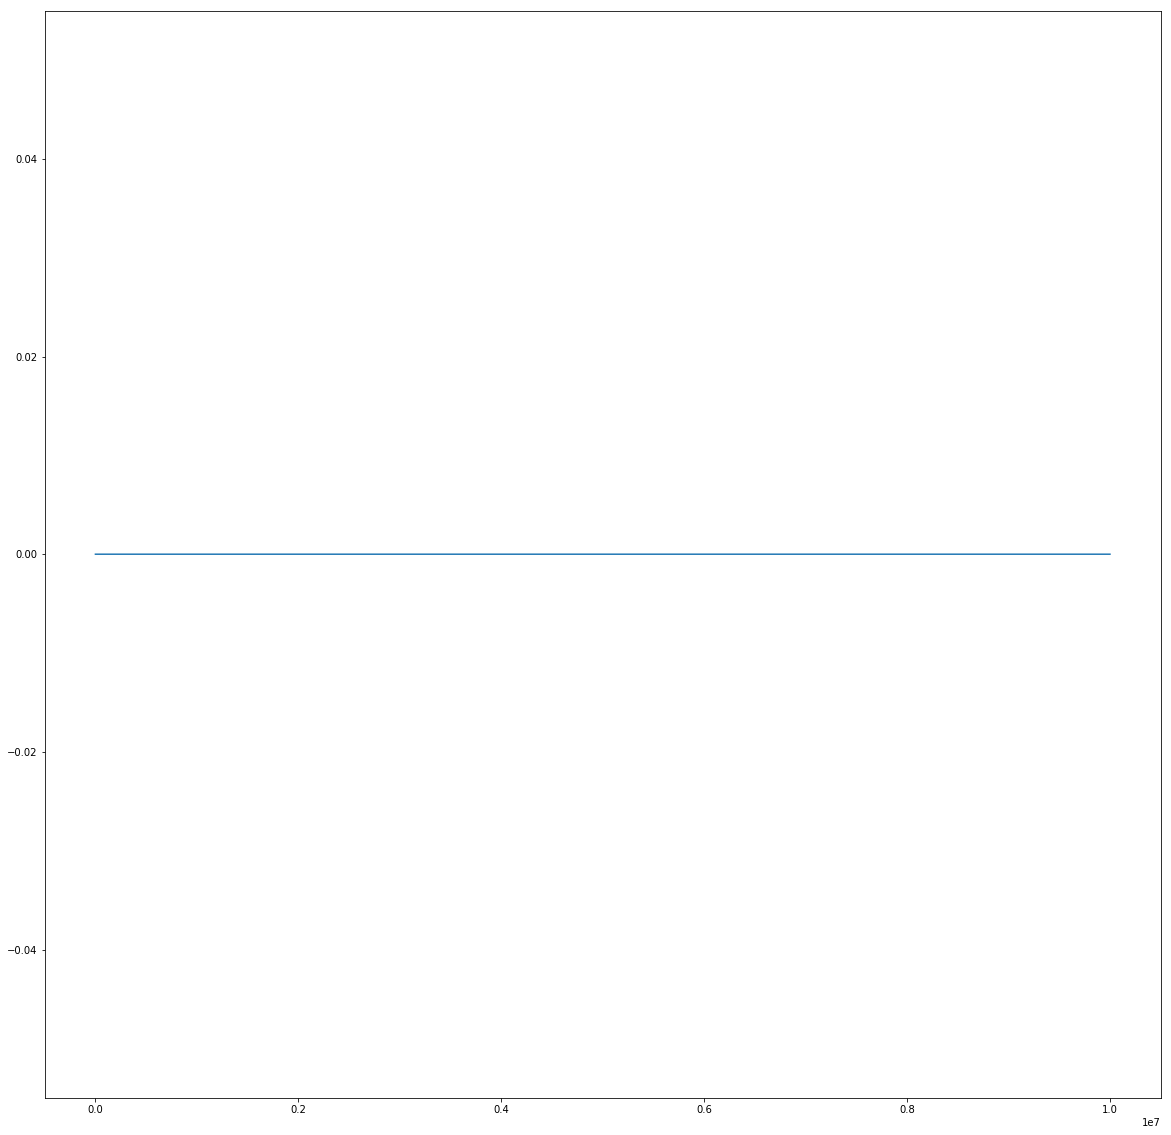

In [34]:
plt.figure(figsize=(20, 20))
n = 0
m = 10000000
_ = plt.plot(left1[n:n+m] - left2[n:n+m])

1999


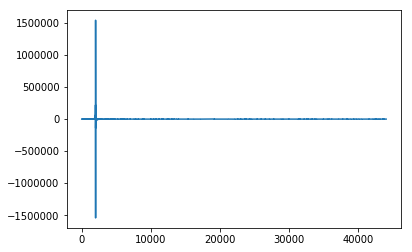

In [25]:
fft = scipy.fftpack.dct(left[:44100], norm='ortho')
plt.plot(fft)
print(fft.argmax())

Далее попробуем написать какие-нибудь преобразования входного потока данных, основываясь на разложении Фурье:

In [236]:
def drop_weak_freqs(fft, remained):
    fft_abs = np.abs(fft)
    fft_abs.sort()
    #fft[:] = 0
    #fft[1500] = fft_abs.sum()
    fft[np.abs(fft) < fft_abs[-remained]] = 0

In [234]:
def transform(input_file, output_file, func, sample_size=2000, file_size=-1):
    left, right = read(input_file, file_size)
    for i in range(len(left) // sample_size):
        for side in (left, right):
            sample = side[i * sample_size : (i + 1) * sample_size]
            fft = scipy.fftpack.dct(sample, norm='ortho')
            func(fft)
            ifft = scipy.fftpack.idct(fft, norm='ortho')
            ifft = ifft.round().astype(np.int)
            side[i * sample_size : (i + 1) * sample_size] = ifft
    write(output_file, left, right)

In [272]:
transform('richard.wav', 'test-richard-2.wav', lambda x: drop_weak_freqs(x, 2), sample_size=4000, file_size=-1)

In [278]:
transform('bach.wav', 'test-bach-1.wav', lambda x: drop_weak_freqs(x, 2), sample_size=1500, file_size=-1)

Преобразование, произведённое строчкой выше, делает из исходной музыки аудиозапись, в которой спокойно на слух различима мелодия, хотя количество информации уменьшилось в 2000 раз!

(Можно было бы написать на базе этого какой-то поиск по мелодиям, если бы я знал, как убирать шум)

In [254]:
transform('war_and_peace.wav', 'test-speech-10-1.wav', lambda x: drop_weak_freqs(x, 10), sample_size=2000, file_size=10**7)

Речь довольно хорошо распознаётся, даже если оставить 1% от исходной информации! (см. строку выше) 

Вот по этим графикам можно оценить, насколько хорошо речь приближается таким образом:

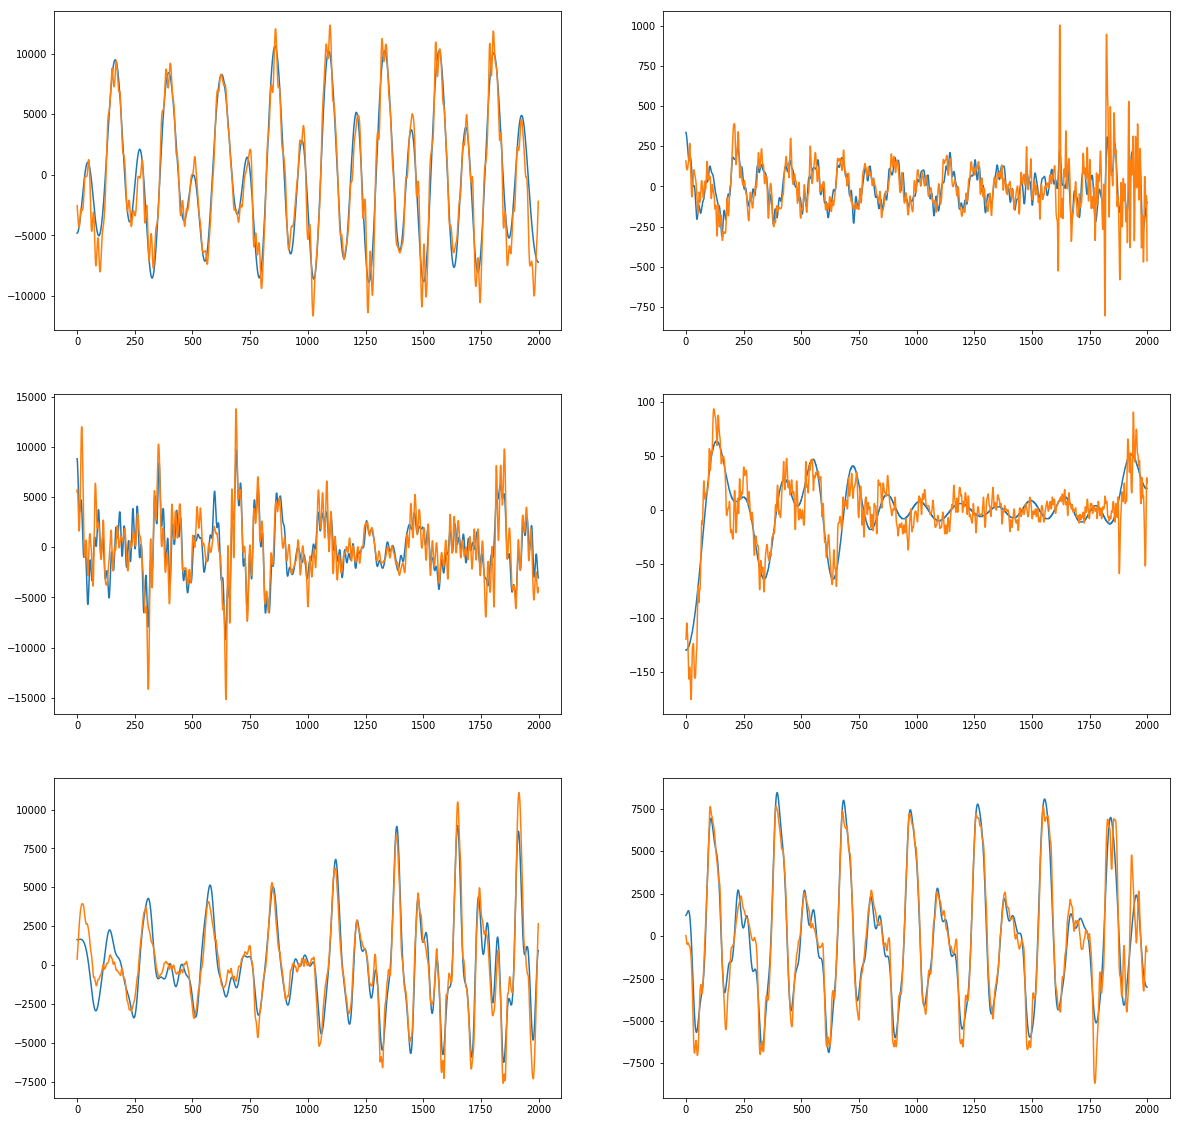

In [256]:
left, right = read('war_and_peace.wav', 10 ** 7)
sample_size = 2000
plt.figure(figsize=(20, 20))
positions = (150, 200, 250, 350, 400, 500)
for cnt, i in enumerate(positions):
    sample = left[i * sample_size : (i + 1) * sample_size]
    fft = scipy.fftpack.dct(sample, norm='ortho')
    drop_weak_freqs(fft, 20)
    ifft = scipy.fftpack.idct(fft, norm='ortho')
    ifft = ifft.round().astype(np.int)
    plt.subplot(3, 2, cnt + 1)
    plt.plot(ifft)
    plt.plot(sample)

Посмотрим на распределение компонент Фурье, чтобы убедиться в том, что действительно представление в таком базисе весьма разрежено:

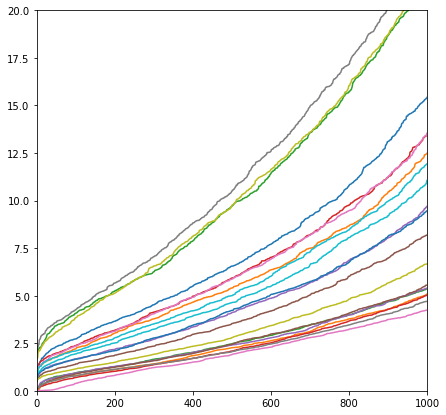

In [264]:
left, right = read('war_and_peace.wav', 10 ** 7)
sample_size = 2000
plt.figure(figsize=(7, 7))
for i in range(100, 120):
    sample = left[i * sample_size : (i + 1) * sample_size]
    fft = scipy.fftpack.dct(sample, norm='ortho')
    fft_abs = np.abs(fft)
    fft_abs.sort()
    fft_abs = fft_abs[::-1]
    plt.plot(1 / fft_abs)
    plt.ylim(0, 20)
    plt.xlim(0, 1000)
    #plt.hist(np.log(fft_abs), bins=20)

Судя по всему, если частоты отсортировать по громкости, то громкость будет убывать обратно пропорционально номеру частоты в списке. Это заставляет верить, что Compressed Sensing будет верно восстанавливать исходную выборку при минимизации $L_1$-нормы.

In [42]:
left, right = read('war_and_peace.wav')

In [57]:
left_copy = left.copy()[:44100*20]
right_copy = right.copy()[:44100*20]
left_copy += (np.random.randn(left_copy.size) * 800).astype(np.int)
right_copy += (np.random.randn(left_copy.size) * 800).astype(np.int)
write("noised_speech.wav", left_copy.copy(), right_copy.copy())

In [55]:
n = 300
psi = []
for i in range(n):
    arr = np.zeros(n)
    arr[i] = 1
    psi.append(np.fft.fft(arr))
psi = np.array(psi)
vec = np.random.rand(n)
f1 = psi @ vec
print(np.linalg.norm(f1 - np.fft.fft(vec)))
f2 = np.fft.fft(vec).flatten()
print(np.linalg.norm(vec - np.linalg.inv(psi) @ f2))
inv_psi = np.linalg.inv(psi)

6.523518800052848e-14
1.2576309565612693e-13


In [56]:
for i in range(left.size // n):
    sample = inv_psi @ left[n * i : n * (i + 1)]
    sample.sort()
    print(sample[-20] / sample[-1])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in cdouble_scalars
  after removing the cwd from sys.path.


(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(0.7160278413266163-0.1521964160123925j)
(nan+nanj)
(0.4836566608313687-0.17261063881692085j)
(0.33983538864035406+0.3048519441955835j)
(0.23082950378118106+0.23704911130111664j)
(0.25704828278681674+0.39295925260113507j)
(0.5514162552411721-0.23403788904589232j)
(0.07393863256828839-0.010295426406435444j)
(0.42788029248891446-0.747321883582867j)
(0.4486963307297931-0.23567446440711254j)
(0.4008734395459723+0.09069207185688913j)
(0.5482827652829521+0.2170805035165895j)
(0.38777742557799666+0.6716502031293548j)
(0.5168361639742296+5.223384046073007e-16j)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)


(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(0.8371603444461522+0.6082325929997514j)
(0.30119167438024036+0.14943888681182066j)
(0.43055562771108397-0.06359907004780335j)
(0.6199577066977829+0.2158921152063292j)
(0.35204839466030746+0.06451341425383246j)
(0.4908551695017434-0.09105217993177973j)
(0.3700658340627116-0.36155241899381396j)
(-0.25804263843915526+1.3131413235815568j)
(0.39997367039812953-0.04717070957958005j)
(0.3775595944946057+0.12365174081367993j)
(0.18529529737874154-0.33211045846262993j)
(0.4764160792253384-0.0323632584535468j)
(0.5183172334126194+0.0009781203856157048j)
(0.5790041083417914-0.24200175073468239j)
(0.39166550679534506-0.1953796067129609j)
(0.24073927358962133+0.6217966418084651j)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(0.5511176916276682-0.6120782054654686j)
(0.4805953004622177+0.06483692294684724j)
(0.4404741715751744+0.018461337615228595j)
(0.4871787671948998-0.9920669690678642j)
(0.25762079336022103+0.343923443666

(-0.020718964840648217-0.022814548616248417j)
(-0.017698714802167514-0.02201853567179899j)
(-0.0018594873943709137+0.0008171154928664116j)
(0.08679246374678647+0.07264584507572272j)
(0.002427176543989571+0.00565072304003729j)
(0.058883477962705294+0.03154652457382306j)
(-0.004411158058787859+0.002517859772171777j)
(0.00697684849550995-0.012070796143709322j)
(-0.0012040931235262993+0.023490631089494236j)
(0.07229428669390527+0.06279599934710389j)
(0.010250282904862523+0.0036264845951748757j)
(0.012930849602592462+0.03673215422729232j)
(0.09071383632514558+0.0381286239135382j)
(0.1852840713679138-0.20687497519328402j)
(0.059075087391130945+0.1966614000739107j)
(0.20744849456327133-0.028387214213073213j)
(0.027346960978928823+0.2476452804203349j)
(0.2342321581588171-0.7228644057539506j)
(0.8795906772918554+0.8055512678161977j)
(-0.09387679793185562-0.45712406502062497j)
(0.24009266389598644-0.06109440473747936j)
(-0.18392119699781415-1.6312527960499217j)
(0.24055571290529756-0.03909424203

(0.07611838490201397-0.03873633771502659j)
(-0.03798454260012853-0.009718421778441464j)
(0.0031804287661061892-0.003931845933018639j)
(-0.0042082816137394416+0.05776903353400884j)
(0.051462874719298+0.031035811733477053j)
(-0.007701380224197377-0.04236031177219264j)
(0.002923589983620404-0.03295862300868501j)
(-0.006499305543245526+0.05734770163278734j)
(-0.0012490763813475566+0.012729457889444044j)
(0.03214054959720039-0.0005911907460266323j)
(0.016949016014651052-0.02618958371063725j)
(0.10487249385740029-0.006602396278360552j)
(0.03294203965806622-0.04683819887992066j)
(0.7108791939207412-0.9385837342964529j)
(0.2979627785095598-0.16033994167283194j)
(0.06658601547489935-0.11127556781633714j)
(0.07848806911508492+0.36256193456896957j)
(0.303000449948652+0.28233925424048706j)
(0.1499594411014785+0.034998790911652894j)
(0.21457019869324528-0.12961591961404753j)
(0.08729254585152724-0.07027336138467954j)
(0.1858579009972749-0.0767035319511647j)
(0.10275549094823942-0.00880574054610399j

(0.10847150383818571-0.062363827863521855j)
(0.02871176235162672+0.09332113927974287j)
(0.12703365063375419+0.034391966700597396j)
(0.20711623434533202+0.05273377088480369j)
(0.011811391291944895+0.4690832432886897j)
(0.14806098937580525+0.02873085320570465j)
(0.09758966926160655+0.004632147905638765j)
(0.05467258378622547-0.09781648243681797j)
(0.3098636054284876-0.5736590889879191j)
(0.12736324414261285-0.05109744897707362j)
(0.35346011732436666+0.7389871222627324j)
(-0.043528300666085304+0.28287974468410415j)
(0.11746233773391791-0.03489225213776028j)
(0.23556742099652248-0.5092209072265431j)
(0.14127097344970468+0.4594640071780179j)
(0.3773523341215655-0.4503946466960096j)
(0.2526209731152519-0.09496901211497544j)
(0.10460499990127496+0.14126345811717197j)
(0.4052175707828116+0.2770477094896637j)
(0.13693760814477568+0.12749895923207505j)
(0.10352124213764058+0.0994903392531394j)
(0.15390706254500258+0.017192032803301466j)
(-0.026544419356784723+0.6323316315970878j)
(0.325364865041

(0.01634762519738687+0.003993011477518536j)
(0.05954916043713314+0.03146497974489965j)
(0.020659636111403756-0.21818167426850643j)
(0.02623477579075331-0.08703957710815761j)
(0.018037218976230625-0.0527105980425477j)
(-0.01971836348819722+0.02532506833782094j)
(0.1106732704020841-0.08979084881236914j)
(0.08985232463510702-0.11257065279975777j)
(0.4037865010146618-0.14313817870382084j)
(0.017466286461354338-0.038412507589801276j)
(-0.12794162837123446-0.13085025213945092j)
(0.014097672623621377+0.11865145887326754j)
(-0.21406288309992527-0.6224055912663674j)
(0.18749255671765017-0.17736621705168681j)
(-0.005272986954796006+0.5345390502900726j)
(0.2103175226236503+0.20598318984810704j)
(0.0681263897313646+0.0040297909658460074j)
(0.04308498005174931+0.04207415410150485j)
(0.3216887457572768-0.11015248950797943j)
(0.09338938817082001-0.12831096657925448j)
(0.030758751617341894+0.11080269047813483j)
(0.0538310234431238-0.01766165404839739j)
(0.13018876282514072-0.1142760012175396j)
(0.1798

(0.23271977644652125-0.08557955132124304j)
(-0.10523407129708869-0.5383484460546126j)
(0.36315757970177803+0.07214783454853871j)
(0.20858405901211896+0.04837466193000369j)
(0.051925850808372205-0.15198822351041982j)
(0.09307659774737902-0.052732068178217566j)
(0.0085760741363563-0.0588517880626198j)
(0.04134444648469246-0.013118755861527229j)
(0.05826294593465746-0.07666187898966842j)
(0.11396183814429699+0.09333846572508753j)
(-0.022463668655736017-0.7549924869407171j)
(0.22542206547750412-0.06378324513923846j)
(0.035314348771067365+0.2425403360358869j)
(0.11952685455598694-0.10635889605483173j)
(0.17098575752822226+0.030778498249486818j)
(0.038193618065076984-0.03255772196854771j)
(0.0021074928040938127+0.007278481005218077j)
(-0.13989336341529496-0.07761340773257126j)
(0.0498161232091721+0.02048280442061031j)
(0.00877340634840978+0.02985514698995092j)
(0.046385483426624546+0.012114065924965375j)
(-0.002748137798941506+0.009995832264194829j)
(-0.003272954754368423-0.02513894906002211

(-0.013584916160677613+0.08184133795396538j)
(0.029963825182880443+0.013988731369010549j)
(-0.00521657247236257-0.16917351405829234j)
(0.11987102827087935+0.068716364968752j)
(0.11190399985038826-0.025141176144010548j)
(0.03467236177465401+0.038039682448196686j)
(0.014187994414803149+0.061516856276707305j)
(-0.006501615713749193+0.10674813776701494j)
(0.008187097993286518+0.14688347604512708j)
(0.7221992400248499+1.00771668870169j)
(0.1754059170995672-0.002643466196048863j)
(0.03712695296897905-0.022967934893941326j)
(0.021273281438327536+0.03807276367979136j)
(0.14451436589375363+0.03496215575425544j)
(0.050927657864110756-0.0721167130283252j)
(0.05691459317062334-0.03124171943853863j)
(0.11632762215475088+0.02190842894123086j)
(0.042122111751775944+0.015252404113689375j)
(0.14550580911358538+0.05101345413780945j)
(0.11138743878264892-0.014807178502143376j)
(0.059187272729906544+0.06118960013237166j)
(0.06874895481073537+0.01691021335460673j)
(0.01337690122908605-0.0373614897686247j)


(0.010946782811171058-0.009340111772188167j)
(0.004795549385367751+0.0073425248883962815j)
(0.014473135176468-0.09744368846818825j)
(0.06979286799671516+0.0013382581153503982j)
(0.13831876104149937-0.06356540103288405j)
(0.06030356615391188-0.11831762360143232j)
(-0.12218836277786631-0.4794090371744169j)
(0.14844482451015456+0.16275466589451157j)
(0.05357919717875211+0.18042947935549544j)
(0.2638753034943851+0.08665862351186963j)
(0.2744166787686871-0.16055758381194143j)
(0.6546489744019851-0.4946457716976766j)
(0.13465726252264826-0.044069443906970276j)
(0.6765866742717297-0.6185877990856562j)
(0.2161953112406282-0.02656855352553141j)
(0.10536657847201514+0.06167951204106967j)
(0.1433066159645124-0.027595725673345582j)
(0.07049013042028748+0.10941770235121853j)
(0.2503460697467094+0.04564847541607995j)
(0.026802373295227146-0.09700055447563118j)
(0.05478131514168789-0.13239436471304045j)
(0.19753053321413086+0.3995451423548869j)
(0.13138105358525076+0.09472858792553554j)
(0.1161802442

(0.2646003571266822+0.09241309502444789j)
(0.09722742127779259+0.2660699529522788j)
(-0.03420643766956188-0.40302869513884404j)
(0.16376831923404606+0.08857479648654899j)
(0.1546160591309842+0.06831501363967542j)
(-0.05806655143364231-0.25555290759055327j)
(0.005825425206212253+0.030821649761962857j)
(0.08115735630854609+0.03856219754419601j)
(0.1253919036673811-0.1389610836277023j)
(0.040259112533729234-0.18421317265650322j)
(0.14068058025294403+0.1076642682146975j)
(0.07151813415088215+0.0006594109351320406j)
(0.06441516172914961+0.05682352318013356j)
(0.07401560572577687-0.07059272744060298j)
(0.10103247264418634+0.042450988029065134j)
(0.09775137959552606-0.019553580904236038j)
(0.05006035862472881+0.22793563856646115j)
(0.08781721152476141-0.0538026804785821j)
(0.26350505957483533-0.6102061771041888j)
(0.07453862211358059-0.07534773555781016j)
(0.09649913491009596-0.040836255195210266j)
(0.07801218579865012+0.12662363167061708j)
(0.16611752920860987-0.3744252557263815j)
(0.1022138

(0.09526965215845734+0.07016142315191022j)
(-0.37742704851461295+0.2661608111541461j)
(0.03414701735671893+0.18633323644359445j)
(0.09570869838874789+0.0025570452104707944j)
(0.16287496403495857-0.47654628114655206j)
(0.07351335147599634-0.2918274092351981j)
(-0.09456198612962322+0.5174058606261938j)
(0.185073303934295-0.0990124893715565j)
(0.11111353046753224+0.15331347420326746j)
(0.14586653425787516-0.13514931716184655j)
(0.10444760393601915-0.48561970893310036j)
(0.38393726110214244-0.8467750626520868j)
(0.167975991832113-0.004376432410673651j)
(0.27683367520899077+0.1333479882267755j)
(0.28411732349059143+0.09617210668494451j)
(0.20436855978271218+0.19063741957405692j)
(0.05782519030262163-0.1282837112490836j)
(0.21319710726332508-0.025461442500079628j)
(0.1902900354880386-0.20792618003228536j)
(0.38420471689835545+0.23003889547394474j)
(0.1941313928334664-0.14044211579210497j)
(0.14439467656576813+0.20521522198422135j)
(0.0952125183858629-0.03009098646494912j)
(0.1643626523239385

(0.9750090404024206-1.6313725007613913j)
(0.059163216489500486+0.04247972413535033j)
(-0.0184677237879271-0.1469749404359685j)
(0.18489743371703327+0.2268212763695356j)
(0.0019080266399761966+0.07323315090944181j)
(0.018413461682019138+0.00246851920614724j)
(-0.051811339288703975-0.03349260475347548j)
(-0.023117930914580247-0.07111725357917174j)
(0.0135560049136491+0.03636251513637494j)
(0.01977354271666154-0.011262498362201629j)
(0.08899836253337291-0.011014231185893225j)
(0.013944788481038084-0.12621874881813822j)
(0.06989233179254674+0.17255154505613826j)
(0.010084249047647884+0.012203990185492323j)
(0.043320963176805595+0.013834743564276709j)
(0.07328938763282701-0.025753751255316443j)
(0.14885966045897212-0.34076943735175863j)
(0.0002810833541703958-0.001773230103278503j)
(-0.01125680236351224-0.015519060799855683j)
(-0.05045323634664179-0.015391551236914984j)
(0.12069255612866878-0.07592565986435955j)
(0.3054187079030296+0.09265541433621179j)
(0.06914238623211243+0.03537716321382

(0.20784642767391326+0.04558790503391175j)
(0.0760361743737546-0.057341537504474925j)
(0.03070619938458258-0.03045412264967818j)
(0.013735356599468264-0.021473300860531133j)
(0.08672735830044195+0.01786992082316033j)
(0.02149935972451143+0.013917970713542642j)
(0.043607444134258856+0.006438380270407646j)
(-0.17238223588479865-0.522612280245763j)
(-0.007902195205838942-0.007928379533115456j)
(-0.06588481928544228+0.13723893819575894j)
(0.055439151279617446-0.011486243648676146j)
(-0.019813714299504265+0.07199341515932978j)
(0.015264591434778403+0.008085310850832804j)
(0.07786281029177558+0.015884318165505205j)
(0.639597565589169+0.749429045717228j)
(0.009723382186638391-0.01026110690814643j)
(0.021769316644222762+0.012872832458493126j)
(0.02991444854891908+0.0024122464237650598j)
(0.09110557323006316-0.06153520385685303j)
(0.07766458490373017+0.03463250491981529j)
(0.04557010970459547-0.16989209500406224j)
(0.09362473666187533-0.002070166340623862j)
(-0.1469396745055869-0.21455025535201

(0.05069453611705194-0.03713030775926379j)
(0.2855062475584303-0.2636882408035465j)
(-0.2375383092217652-1.3607875613270397j)
(0.3471417653566406+0.0017629239043173422j)
(0.23319403747694795+0.5855875131216798j)
(0.3257962414428788-0.6675938616029696j)
(0.09414567147392744-0.015934971922567032j)
(0.05117915919074116+0.14378499573381498j)
(0.07056363870366399-0.10098718982143513j)
(0.19699034876784313-0.029183679192225188j)
(0.11122089942495673-0.18847586061749022j)
(0.2709977692876478+0.22741314658724435j)
(0.15922974842497745-0.026202368465112993j)
(0.15454756435374517-0.10756460100152092j)
(0.3158364833583304+0.22814000695884584j)
(0.02743878572600819+0.005454834976238024j)
(0.047588884642134274+0.020966720333943496j)
(0.0014552973127458554+0.011682226509209971j)
(0.024597679712717344-0.00833068185995735j)
(0.042259421245481946+0.15940698065063721j)
(0.022417662279175563+0.012418767928435846j)
(-0.10947579512215268-0.10150296199527493j)
(0.003148426328753186+0.015878171352763704j)
(0

(0.12606891143165747-0.0561904537339304j)
(0.07084171826133513-0.03661958458759734j)
(0.14001884831875777+0.3051711975356319j)
(0.060745450649969175+0.013164391580373646j)
(0.18754684967575194-0.14417765068681374j)
(0.023903557120273984-0.04020132550723281j)
(0.10914693540583827-0.10819174448334919j)
(0.46201324116667436-0.13223379519279438j)
(0.17506278508511883+0.2056731907297936j)
(0.12741024512312735+0.322659510482345j)
(0.2252401252404706-0.3489671265814626j)
(0.17401756198356544+0.04591894208213824j)
(0.03015274033688273+0.005454795890753439j)
(0.08498519647276023-0.36014412613495245j)
(-0.041095909061548294+0.1261720555278413j)
(0.01938077610507862+0.14030837761231457j)
(0.02183792991620427-0.0019264196235674472j)
(0.00803715429383732+0.011512081194332844j)
(-0.2550419305314487-0.33977004171245095j)
(0.07997835058693331-0.051482307012628764j)
(-0.00974878398061256+0.020549231336656135j)
(0.08095518520057095-0.05898013402403304j)
(-0.010962227593348334+0.027235186613752432j)
(0.2

(0.2462023956446805-0.20097035703276625j)
(0.11979875881250236+0.16493032179055891j)
(0.24637050486037554+0.6261829080913769j)
(0.07387236751882749-0.017878331484659348j)
(0.23404501997091065+0.2033044971609348j)
(0.22656682092929506-0.10275994172820169j)
(0.10550551372785032-0.1784320449690327j)
(0.20703713037290292-0.10497246855896418j)
(0.16023932488653034-0.880152786057809j)
(0.015760135380707467+0.059098678306697766j)
(0.023391687370321153+0.19646940635515261j)
(-0.006669382281698361+0.11763150607713903j)
(0.012768103796087948-0.034606628825846246j)
(-0.010992467274829137-0.19438210847586956j)
(0.0027657493857942035-0.002669070874153731j)
(0.036831053161012386-0.004119832863609495j)
(0.0065243623568751845+0.010156477543205887j)
(0.0020306320999348274-0.0017940741027427888j)
(0.011775104241594184-0.02633660480843296j)
(0.02283858384563076+0.052653522652116494j)
(0.0596783715429336+0.000715095852847889j)
(0.02268617320809615-0.11297376849521157j)
(-0.05612033957344731+0.142677548666

(0.09067588840290561+0.017928696305330862j)
(0.03356689009743975+0.015370357121376651j)
(0.1019784484183681-0.024871031869272878j)
(0.14764175853374478+0.12406852359281825j)
(0.138566243950194+0.09397570749821868j)
(0.0636142412389511+0.03419440592600489j)
(0.039705330933294244-0.027689502538071044j)
(0.03772248624969244-0.060634777387866955j)
(0.06369581685446157-0.291390749918825j)
(0.0894655862816077-0.06958502645264178j)
(0.049119249017888215-0.0864543018070742j)
(0.03176385068351087+0.08217947697332144j)
(-0.012977650145812192-0.08829673523022401j)
(-0.007051508940498852-0.025435050865966258j)
(0.10265145537803655+0.041248214653169114j)
(0.08766628539828955-0.012782156072137878j)
(0.12462900182600507+0.07183247626376607j)
(0.11858336541145705+0.045171562065127534j)
(-0.04180948748711441-0.050945781505519976j)
(0.04307138311138157-0.023401288113025533j)
(0.0885360111978202+0.2400259926233779j)
(0.007874301204148162-0.05897947307999906j)
(0.03547617538557752+0.10812073039061816j)
(0

(0.07571617400474931+0.03268617053422464j)
(0.06001854301617072+0.0635600229311388j)
(0.1632597228664149-0.00447101935349669j)
(0.023843535592159168-0.2581401562056379j)
(0.3460422580460642+0.021710046822192137j)
(0.08687262768206039+0.0721076037331926j)
(0.22222636903811185+0.010817124012426786j)
(-0.007967147238831218+0.17284008178287844j)
(-0.11300785311162301+0.2977054600200678j)
(0.027267911497021853+0.015567377707521073j)
(0.003615049793893927+0.021642546555641313j)
(0.02849290630371711-0.013327111378790186j)
(-0.01065290722567027+0.05397104964620208j)
(0.007887666334531942+0.08503136764595995j)
(0.14277779977238422+0.11879284217649479j)
(0.06436163558549644+0.08335453684306901j)
(0.31746845990282596-0.028445997678447875j)
(-0.1414543843997716+0.09981915450920635j)
(0.007438588147162514+0.001974285287515303j)
(0.0653715865978857+0.11235587712012779j)
(0.06235200850284437-0.32895647706824904j)
(0.02592016625103103-0.0777782818092407j)
(-0.077395160608063+0.26664109786186535j)
(-0.

(0.3157555456547404+0.5673328661436865j)
(0.16180987290568744-0.21621149865675543j)
(0.5329143245505292-0.3746414744855427j)
(0.17231202428454662-0.004382416749062314j)
(0.12668186883111243-0.024495625771346927j)
(0.35246355353754766-0.06243162664182787j)
(0.6663913390524008+0.47734291220081904j)
(0.1669212077401827-0.4490543366602432j)
(0.23970825459054107-0.4291645127806717j)
(0.3566986661364987+0.0027961466515474933j)
(0.05705602363051236+0.009095576822854471j)
(0.0755737176275904+0.19251537870757654j)
(0.7641199294632517+0.6264409919712913j)
(0.23660298962093557-0.07412804667798036j)
(0.18197406286373935+0.0014518041822113605j)
(0.2645484214856467+0.439010697042402j)
(0.20753057283155638-0.15457315473797395j)
(0.03958206871813272+0.09035210945049336j)
(0.030174277500841878+0.024395558889636675j)
(-0.028408190954327745-0.06315166852727216j)
(0.053693360040291724-0.021733826775303642j)
(0.0418921270994814+0.05865808370608388j)
(0.0750177970564186+0.04341790862213497j)
(0.045579564377

(0.04164689185382226-0.01163316228313975j)
(0.05370230487987078-0.023609238936587167j)
(0.03179927032411031+0.013713627260296462j)
(0.04433280600558595-0.04573256738290361j)
(0.015413935408818006-0.035650782501919775j)
(0.05587847240913937+0.012111260362090079j)
(0.021885612460818427-0.03383425159286027j)
(0.05294683832685958-0.0006750384225418823j)
(0.1049382781443291-0.08528702467987509j)
(0.11808382888560279+0.08329915070805331j)
(0.06981754081559331-0.07973083383395772j)
(0.15456838386337793+0.015581039559276083j)
(0.24199680609574428+0.0692152469465195j)
(0.1351531888509363-0.16239596163003894j)
(0.06838525639186908+0.0493281491054743j)
(-0.10297075448106173+0.2592692466687282j)
(0.16115689372050115-0.030485446787347156j)
(0.298036486544075+0.1374957797224888j)
(0.15598825474175423+0.008759617690848927j)
(0.07611091586758875-0.03450274561206181j)
(0.01766884476434229+0.04187481901699094j)
(0.06500159993672212+0.016669652386705678j)
(0.11961938061578427-0.0715512473209187j)
(0.0896

(0.06538058060878506+0.1824565003314716j)
(0.015674190628909075+0.0029253797352030626j)
(0.00031750604301532937-0.02450129398499515j)
(2.0726200514415548e-05-8.541254744286978e-05j)
(0.014140171215265653+0.006265292608825116j)
(0.008575225073935313+0.003714645047277116j)
(0.013609554560615312-0.02065299957989968j)
(0.2776622141548059-0.23507367847311617j)
(0.018563735318794548-0.007900256165842771j)
(0.03858012821749357-0.06032119170865407j)
(0.0063785006738173505+0.00015932840109631052j)
(0.046153154204773644-0.01709603140755803j)
(-0.0020226581330586016+0.13211308112076434j)
(0.00809840808226623+0.03359266345619993j)
(0.0054210115974194385+0.0740055352319451j)
(0.0038190047877000362-0.022494377382572373j)
(0.04081702006123642+0.04099961830862522j)
(0.04788915107308449-0.003854535120392951j)
(0.04064000962489864-0.012174787029958603j)
(0.05576509082209902-0.09816168146278494j)
(0.03532424893247778+0.002044940360359727j)
(0.0344305024131785+0.05223371827047409j)
(0.08594350812078357-0.

(0.20798004994218663-0.16055044962266812j)
(0.08600358432639944+0.04102721992706547j)
(0.025610162641776665-0.33221318065997135j)
(0.182974677445527-0.004403252988866062j)
(0.05310192193525071+0.06269065688256319j)
(0.1815033627157246+0.16778559517874225j)
(0.10083113511303482-0.5808340434568446j)
(0.14093523390906526-0.1944753811004945j)
(0.39331037862781326-0.350183361828963j)
(0.044587894193638275-0.09256783035803505j)
(0.1729567882517014-0.12956754479463328j)
(-0.008237407706224598-0.027442778653955543j)
(0.1318409582927756-0.07556592878401826j)
(0.03309380033347667-0.011065943969432697j)
(-0.007183571645034362+0.047905751561924184j)
(0.025280238172109105+0.014836428609522686j)
(0.23131184727121928-0.380985816604893j)
(-0.02969156884132098+0.010481477002169065j)
(-0.0002071320174141424+0.026905725802386968j)
(0.05865499150485263+0.06699788309920726j)
(0.013816914918124798-0.04091201937760303j)
(0.002290211368891074-0.006749366230546448j)
(0.01592107700474621-0.025951024399807152j)


(-0.029364053508472817+0.0663801741367275j)
(0.07102718148423219-0.09016135803768105j)
(0.010445507370517108-0.010942536622109237j)
(0.16536087758540102-0.38110638293829163j)
(0.056319140553755094+0.03735224529674588j)
(0.07481902830163903-0.029272038632243993j)
(-0.1750672732503348-1.0821736039072183j)
(0.04153153220430542+0.046158338602974115j)
(0.28507486678677624+0.11353226664674677j)
(0.05136247945109842+0.08051285314034576j)
(0.03918020728600166-0.0014383147113969587j)
(-0.007014681478352764+0.05101668393542069j)
(0.10737922670609289-0.01846884010780604j)
(-0.021760556921123844-0.04878269038608367j)
(-0.05813334149155242+0.1868877482904932j)
(0.007016165374912722-0.0030223705109374602j)
(0.053370815269965316-0.018598875048755494j)
(-0.010930485691415175+0.010863706842947102j)
(0.0030100347058302844-0.005547028500541788j)
(0.010199562320875476+0.010861172010449447j)
(-0.001076070397130994-6.318609245693322e-05j)
(0.04269375518523379-0.009437401973754204j)
(0.0003324752148745084+6.

(0.02015646178259414-0.019632123173930753j)
(-0.0027701422014252608+0.013354010991568204j)
(-0.22227701653835752-0.2542493532209631j)
(0.13442446713330602-0.0742614997038713j)
(0.02543943942772129-0.03231677685264951j)
(-0.054053358527943504-0.022216189443000706j)
(-0.08348724072412245+0.08375727849468163j)
(0.02985966191406345-0.050401700201496376j)
(0.027730517271785184-0.07968530909039681j)
(-0.0017049357454802377-0.03612582930349453j)
(-0.11977690688220335+0.16264779432887114j)
(0.010045899347796927-0.015739387956552896j)
(0.21652265308915544+0.004682759258164326j)
(0.010020689464366033-0.002761936590267699j)
(0.1636886605423914+0.14644603042383084j)
(0.030745306421697913+0.09894541448820926j)
(0.08076036570989885+0.028057810913619637j)
(0.12583862267479987+0.25612495783822886j)
(0.10237144018894068-0.0723427175240323j)
(0.16343107483688776+0.16955710952780118j)
(0.13317059756365127-0.09074135722811937j)
(0.057487990708242794+0.005946887435840382j)
(0.17235532037177753-0.0087951903

(0.06780298926782369-0.06704810016995337j)
(0.1300058746521743-0.3368229872598318j)
(0.11963813822772917+0.18772650414417744j)
(0.29357225468321735-0.12532422325996306j)
(0.15069766410648558+0.06551274484429048j)
(0.18441673432913067-0.10915783756974438j)
(0.1994763077400475+0.41043995759793744j)
(0.15982734879215618-0.11107215209055256j)
(0.3292032394401054+0.16268645547148183j)
(0.00258683983199966-0.2256240278007815j)
(0.02425522048904486+0.0450681678620218j)
(-0.18068595603818838-0.10083841236636773j)
(0.06496670293466039+0.021269871168360502j)
(0.12150164925829347+0.22365705128417723j)
(0.142456151677461-0.10401031600996977j)
(0.052043961226639505-0.1114174831181591j)
(0.08380744028239391-0.066038785377812j)
(0.07548712981538576-0.06234519628393023j)
(-0.1294184136104554-0.16702550321356777j)
(-0.268315648599785-0.5333720741799178j)
(-0.00582680804483027-0.05532859352659004j)
(0.0022225560002847255+0.022808718064602853j)
(0.04327083940420756+0.08702933997677158j)
(0.01451594145157

(-0.002762749794727069-0.13550557886526982j)
(0.11618674230908843-0.2054089178619141j)
(0.038075711351833505-0.14964162751335264j)
(0.0013863643120428102+0.016218122854461933j)
(-0.016821793923707494-0.06160151962851922j)
(0.04964633249589399-0.02596813255077177j)
(-0.0035044258428970107-0.004870523824339075j)
(0.004223062518968998-0.2566097507157676j)
(-0.0009770742005938123-0.013144356396686782j)
(0.07317452136296944+0.04742580390286025j)
(0.021551285249795184-0.006395290678152249j)
(-0.04011859769808204-0.19158530911886054j)
(0.10172315765588366+0.1093577779262875j)
(-0.003540249556234833-0.03400356730980692j)
(0.013668202629522544-0.008632463936495463j)
(-0.06128330047150438+0.08853111436617098j)
(0.04457665028972749+0.03718304439912949j)
(0.12305074374024229-0.01685340709726731j)
(-0.7000817555251829+1.940812924858226j)
(0.08431940618741988+0.12864778269176308j)
(0.32147649373336606+0.3257372337231196j)
(0.05542706534671994+0.004938595709595031j)
(0.13221862054973282+0.18906888782

(-0.010228717550231255-0.16252513398375937j)
(0.08782084584460101-0.5945176945273346j)
(0.27386422976742136-0.1715477631606923j)
(0.08021079610684005-0.01864895251572081j)
(0.07163629268682643-0.19949654026513966j)
(0.039049330990790734+0.3520097150389835j)
(0.14342608941527055-0.04276020695819531j)
(-0.4700473119007406+0.7675377435864635j)
(0.10366279463324955+0.03828759318594395j)
(0.14410057054091252+0.1631993926917204j)
(0.5073527803189646+0.4825545066343154j)
(0.10162928905400019-0.0025318168975286656j)
(0.23695827815639675-0.20163425563153442j)
(0.30001002004825733-0.15876848912926358j)
(0.16580310467996873-0.012027866820092733j)
(0.12074163693339311-0.038807592669935644j)
(0.21401915295919113+0.44787271181684196j)
(0.6657360340872379+0.44719509081560427j)
(0.20243623147307327-0.3742172247636345j)
(0.099059325702527+0.06556124687489735j)
(0.13128479199196944+0.12432744738921145j)
(0.155394125136263+0.020810676267584816j)
(0.19872113338308212+0.2085773200067065j)
(0.09461383772760

(0.036817917313021094+0.36147196257378456j)
(0.1611115849547473-0.13155911184769584j)
(-0.09086697451782107-0.2507627881267161j)
(0.25085004847322384+0.055266484086348815j)
(0.18464604247281263+0.08242860222021949j)
(0.09130819529294346-0.03182217307913741j)
(-0.016821912489381367-0.5101889244404189j)
(0.18543971998570746+0.0008946052507563301j)
(0.15133421485328288+0.08752347693973662j)
(0.05883009114683593+0.03007034594332738j)
(0.12032299869873891-0.03030649159399425j)
(0.08315950243743199+0.1786190187656083j)
(0.1659507691135412-0.3321232575019526j)
(0.12206381142478737-0.07294197008667802j)
(0.07549688019875013+0.13873438640891475j)
(-0.27432573747692696-0.2282252312593253j)
(0.1146192763516821-0.04792576685379187j)
(0.06475214311451545+0.11226479431729497j)
(0.60773770865073-0.3104775986082446j)
(0.036905567067597365-0.26759709311704355j)
(0.24875396418686635-0.0029052896304088303j)
(-0.11495716938408572+0.5033416801759181j)
(0.2902307608321438-0.047320764663322225j)
(-0.47184290

(0.035734413913246776-0.009919815963945429j)
(-0.021002001757001874+0.08138523070865929j)
(0.11500159993716223-0.2848928302486617j)
(0.11828328771279158-0.08328948627115881j)
(0.28446195609972236+0.027852038587023314j)
(0.3162025109335169-0.11657323317154787j)
(0.21522838546076611-0.0020962182815570936j)
(0.08935260171630187-0.08612913500854971j)
(-0.006015861159928651-0.028176450298612772j)
(9.048931488260435e-05+0.09913017178232886j)
(-0.0032727129026491283+0.012274836521064772j)
(0.10084127234503887-0.057653576933191626j)
(0.08656191664788206+0.18967739638884248j)
(0.0048558745250807155-0.029552955995700108j)
(0.12133515804272808+0.043323686370049665j)
(0.01689098768424279+0.019117424749218192j)
(0.019857969194114304-0.025429768637475893j)
(-0.007309002365737666+0.010547833594619959j)
(-0.019338834703939087-0.06681289911760052j)
(0.09694398592422307-0.2308141902548042j)
(0.019571237834512215+0.056501987686507625j)
(-0.021958108220345808+0.09227421860788351j)
(-0.00972886787122099-0.

(-0.15946069042510527+0.23057757740530405j)
(0.13641848764941122+0.045468684288057365j)
(0.08559206516024827+0.1130274131505413j)
(0.04118669876072949-0.041931274524156875j)
(0.14578465547009486+0.08571919924792916j)
(-0.12348225689579802+0.5543053826600438j)
(0.03403094087931829-0.028905646401276446j)
(0.024068227348451498+0.04847758708946561j)
(0.1552509844330277-0.009336186757933986j)
(0.014399219097970983+0.056063994009540284j)
(0.046636350397759575-0.05856574317223593j)
(0.08536630743418583+0.05310146547482689j)
(0.08524952931137797-0.1568315624786291j)
(0.0815376796571824-0.056090182925196776j)
(0.03259923558553831-0.01501699413813957j)
(0.14175564087437706-0.14210405226045955j)
(0.03369482983230516+0.04447712804230909j)
(0.041028820609433914-0.0142491509974691j)
(0.08502895019987387+0.023944933768741176j)
(0.15866907336998753-0.15217536416589764j)
(0.17829101278298953+0.11578345169056584j)
(0.09410962271564995-0.0046001878083878145j)
(0.024910471256613206-0.02130182358363136j)
(

(0.01423521854366697+0.1213131361679417j)
(-0.031361190874750505-0.050469979850793864j)
(0.027998315876672262-0.06779589806838068j)
(-0.015466572397176246-0.13833919585853616j)
(0.035491288755674213+0.044393838984032936j)
(0.23386141990382125+1.2852799352907827j)
(-0.19630485944880538-0.4856856888946142j)
(0.11383845584733987-0.10748975443065947j)
(0.36029583883326194-0.2677229737654669j)
(-0.11295965974959993-0.5219324732524783j)
(0.08834272795462617+0.022681176370793064j)
(0.11574893619087065+0.21520500337006987j)
(0.07528060517060717+0.011981424586449772j)
(0.1420735156728922+0.10517730054808833j)
(0.05468964441530579-0.15832676733901288j)
(0.014667593223740862-0.24934946044772086j)
(0.13593356632163406+0.09453397866098315j)
(0.06478552297834575+0.0800729625010677j)
(-0.0964162504315418-0.36860956794774735j)
(0.12715897294343648-0.38804133156388965j)
(0.2470552928626918-0.1356192873795202j)
(0.033478200623826906+0.1869276900155734j)
(0.13700662833998872+0.19576730607487347j)
(0.2281

(-0.0117009446351495+0.021311761713006302j)
(0.027549116707249816-0.0011937982281013735j)
(0.018331250400892354-0.02554877790451177j)
(-0.02701684396704604-0.020654974993576533j)
(0.006851643170095043-0.01275737695345991j)
(-0.0337636143006231+0.06457443002946574j)
(0.009121274728340211+0.02604108234506272j)
(-0.006705143011714325-0.00017817252533734498j)
(0.052158438579641975-0.18465856924578078j)
(-0.019580719581241267-0.002952074292986433j)
(0.0180099778026172-0.01839615620331723j)
(0.0033061388880193487+0.003212518342108512j)
(0.06145939435158372+0.028537989989581458j)
(0.10596390078876008+0.006177449019275917j)
(-0.015946298828193133-0.007761846267384726j)
(0.002364725911792888-0.021245596972247698j)
(0.013690039740595746-0.0029612480026477176j)
(0.010249161627906447+0.005754600623992552j)
(-0.002153175368021314-0.0383328967928263j)
(-0.0013209629655781732+0.10040754833005662j)
(-0.01777308964790604+0.13397117051884108j)
(0.0691027296743718+0.051499707747017405j)
(0.09048785384493

(0.04693969637110822-0.02965296512983928j)
(0.058724309521814996-0.19995824756615033j)
(0.07226009405700065+0.4248288862575143j)
(0.10483444295885046+0.05802129089100722j)
(0.08386281262080131+0.12317112004402682j)
(0.11022437245980521-0.01628930117340821j)
(0.12310948265036788-0.2824308683336771j)
(0.07997989702437253-0.07388180606348345j)
(0.051350584971196205-0.05213808489991557j)
(0.07961913884073535+0.09273398062273748j)
(0.09299166453141934+0.07927696761929502j)
(0.05456887346965717+0.16686822714410138j)
(0.3146580997871382-0.03645122262874758j)
(-0.09750874319135518+0.1773569215759763j)
(0.05847988828499749+0.11676496597174327j)
(0.16437210879069966+0.14285995919939612j)
(-0.018456996512831097+0.16513352693221006j)
(0.011949147287659894+0.0038478127636684565j)
(0.17803164943333263-0.024618889851103744j)
(0.009331684522464532+0.005642180158550351j)
(0.006467483351335766-0.0008173612517996851j)
(0.004622374429018596-0.0033360870365570865j)
(0.02463454176809349+0.01966479989057373j

(0.007876405117228417+0.009318865845553036j)
(0.006957098343652358-0.12269101316837074j)
(0.04672356643752549-0.01580995772404048j)
(0.09682807790084116-0.05148605632474323j)
(0.0003030143386315903+1.4673292364526486e-06j)
(0.029422596644397093-0.1300566640208935j)
(0.06410327696006299+0.08548503161053851j)
(0.7281308350519995+0.37385918171507093j)
(1.5087501077597332-1.203911924273336j)
(0.009220229927446888-0.004000817911816153j)
(0.06496207050016406+0.0010527936741955742j)
(0.11785836340361631-0.14905751116056865j)
(-0.12746737238923295-0.23026187130003836j)
(0.1876137979394614+0.12870336701025675j)
(0.017458843159996122+0.008297156878646428j)
(0.01570936195823115-0.030398960437768692j)
(0.052951489059365045-0.020185362176301628j)
(0.1717161214536172-0.08680275019471809j)
(0.039958890813668574-0.006671051805513889j)
(0.23950732787322235-0.03825444513183638j)
(0.05380149116186101-0.10941339315068352j)
(0.19742573839916794+0.00856925083227938j)
(-0.20655069835426962+0.2983179479405204

(0.010106038769636278+0.003914975572593912j)
(-0.03463940191225644-0.025119123636361727j)
(-0.04431720330281535-0.10357644728412539j)
(0.005932466507929331-0.006278134282238025j)
(-0.008617949941847695+0.08257995663102394j)
(0.05727401028163528-0.00786705614143391j)
(0.08932279377703445-0.03171338024531229j)
(0.040339048197368096-0.01707185487429597j)
(0.051693565554032414-0.10788778769895883j)
(0.044841270857290276-0.05434336099365318j)
(0.055137814694268684-0.003237541044831621j)
(0.0020149286385062358+0.09314396131553654j)
(-0.04551009265681372-0.10482594647258664j)
(0.025761907713344964+0.05638834962014414j)
(0.01000561782504386-0.05505619635298511j)
(0.04142977243673403-0.013791632291022364j)
(0.084586780718743+0.0062275005048826396j)
(-0.16079042902157098-0.19426517021840617j)
(0.02908776927438805-0.044605662296499336j)
(0.006429482728116138-0.037647928779462485j)
(0.014965483429113888-0.021099689937147472j)
(-0.004208633886675177-0.007238385195120265j)
(-0.020084861560525306-0.0

(-0.01931598940080957+0.04131845413158109j)
(0.03305595111099246-0.04689943077215526j)
(0.015320868575002899+0.06762806674143769j)
(0.013493221917283811-0.012843769493571177j)
(0.023864778086331605-0.06468282488484568j)
(0.18580380957347148-0.09908444210093396j)
(0.05468981001078731-0.07141659913536415j)
(0.1754587695015516+0.16255003011912306j)
(0.06599701589165845+0.10501434823341713j)
(0.11233026065383879-0.14195091538258056j)
(0.023271033604346427+0.1938069347441399j)
(0.11863853301400067+0.0794177697660236j)
(0.2136365733724505+0.22536679624517544j)
(0.08959232822494187+0.021407928520245544j)
(0.09362255795491432+0.07599468907051118j)
(0.1113019552112665+0.03675656446633182j)
(0.09331482044498716-0.09376673933664625j)
(0.07240204777300732-0.19362351899128377j)
(0.16001409287421617-0.0501776885514936j)
(-0.041300009232912896+0.29557447328019154j)
(-0.13092353911570243+0.2028279841035379j)
(0.004887976165432719+0.04364474515902648j)
(0.5522043937239418-0.8851682877035838j)
(-0.00644

(0.18646048276516444-0.1611272475989916j)
(-0.2884136624087236-1.5124100315504863j)
(0.2522828508451244-0.08830651365926595j)
(0.24424755074009163+0.0855065363607634j)
(0.07707223778630656+0.07244206805072063j)
(0.27495789499291967+0.05668879146206293j)
(0.18133952402624579-0.07122930899866318j)
(0.08085476090333697+0.3586850467731479j)
(0.1205498645297988-0.04293007704260222j)
(0.26912942238378346+0.29912515460802097j)
(0.4761311926085838-0.573288405495647j)
(0.2577858084503883+0.111353044254715j)
(0.18565531574000815+0.15338116787678394j)
(0.05848390013931858-0.03147303938812491j)
(0.5514446060490346+0.26513374239598264j)
(0.15371425877084013-0.1464033280020177j)
(-0.0767036116399477-0.10167368589465953j)
(0.2102091543882575-0.030241255582405407j)
(0.19783906839106527-0.1890866787292949j)
(-0.0002272682553105381-0.03468792811117721j)
(0.19360586063259508+0.18486023675998284j)
(-0.7594015522376591+1.2225644844383419j)
(0.06128771183261501-0.03401703788924489j)
(0.13958743191196124+0.0

(0.3955876898642774-0.6445357891652908j)
(0.03364692217051963+0.01582884349574237j)
(0.0029206248820383566+0.02245564469200344j)
(-0.044198067226432554-0.11765560128868192j)
(0.07999338328550185+0.05808270236027623j)
(0.0251655930918766-0.0008590619810950262j)
(0.13039514053339796-0.05637531555934328j)
(0.01175510837582538+0.009941928588001464j)
(0.047001884118725655+0.0852902087446763j)
(0.010126436395926098-0.01812802158521419j)
(0.06130515329800119+0.08192890381866196j)
(0.005653227989185454-0.010102683696444665j)
(-0.04767779888825923+0.13561801817208285j)
(0.23677835960678684+0.14748170349385678j)
(0.034706271901221684+0.06240312504637629j)
(0.012981792340524776-0.0041462550430130755j)
(0.07790230127927149+0.04320894200554672j)
(0.033259056007534045-0.0022221828073540318j)
(0.011328046520488213+0.017985046337152533j)
(-0.016070474177993215-0.029378525566771237j)
(0.0759473680078988+0.032684131061611j)
(0.014487174600839248-0.0629769799664114j)
(0.1311657812123556+0.230808854829142

(0.11021247752265201+0.3639089915482415j)
(0.02164495574008673+0.17768509072562133j)
(0.05659208161730219-0.42252716828909626j)
(0.3459689228610367+0.5497092548800085j)
(-0.030316739578338144-0.11743246004600622j)
(0.12546023961420336+0.23112174012589284j)
(0.5903689195323585+0.28221123357244376j)
(0.06905609699159093-0.028828405968897214j)
(0.015251894962025407-0.15294552235135236j)
(-0.06202147584294112+0.08595837468349854j)
(0.31326068840422255+0.13558717009349708j)
(0.09768500693796273+0.05539230935315269j)
(0.01775327645502331-0.005918349279584222j)
(0.08721601302634098+0.05976311407490698j)
(0.029144348787485983+0.04570194423842645j)
(0.026399941614643565+0.03762124382860236j)
(-0.007880773101503343-0.06422939979842371j)
(0.24753973256699344+0.25585658594895033j)
(0.0542411875260167+0.3474713663516843j)
(0.0750788466083533+0.186105157785509j)
(0.16742322672506416+0.04748137489637974j)
(0.3304311508648032-0.16397624503420621j)
(0.08222972046444099+0.006771094693953048j)
(0.2112730

(0.08200461750465737+0.012255155604637188j)
(0.042145908864497816+0.052952791342842816j)
(0.06882916431251804-0.019596198738778194j)
(0.06639302260508577+0.0077518897165370455j)
(0.13006568120022097-0.04141806878356903j)
(0.020131921129913362-0.045037067744494376j)
(-0.2710749479470873+0.38258043754335674j)
(0.02438989154453964-0.030547814692141337j)
(0.1582259973638349-0.0816309224358711j)
(0.054544244585491154+0.13821667410299954j)
(0.50689094751717+0.3435157904341934j)
(0.05304468113977345+0.009831603333576171j)
(0.2378345486814834-0.14860207800002043j)
(0.019079190730988578+0.03321508157251723j)
(0.06799878725523083-0.000534062119826608j)
(-0.010744239846837637+0.013096957545863756j)
(0.08505494485192618-0.009793721238721012j)
(0.0032653591799891263+0.007975402882880341j)
(0.00605348427600541-0.0357502496782549j)
(-0.0030224331144368356-0.00020379087849028502j)
(0.07027313036763017+0.060096677364775135j)
(0.013262624694026583-0.005474640022646358j)
(0.12404896767208262-0.0631118895

(0.30212787450319806+0.09391623832336644j)
(0.0422436729446071+0.13473667738564837j)
(0.19057198189715047+0.6645825150728821j)
(0.0874928143692047+0.09228180608572834j)
(0.032073527386939624+0.0286141147461713j)
(0.052206205365082144+0.045362031008764576j)
(0.052060832898928426+0.05581266406890918j)
(0.043268678549010675-0.01168065271539542j)
(0.03202459291259427+0.027831721418245626j)
(-0.08782828661399374+0.12504390145959665j)
(0.03118622649094581-0.049232292150234155j)
(0.15981519487818846+0.13311590952990823j)
(0.0338601262477413-0.0025766135940127792j)
(0.11263171416893572-0.04901464638037686j)
(0.07836677245729873+0.003186081190132652j)
(-0.012519146495970022-0.015636354571351624j)
(0.048565044290652296+0.00916584776826619j)
(0.07749344768862583+0.07551622872538957j)
(0.008700963676534022-0.014507284448821104j)
(0.015326182146513635-0.025864793150955887j)
(0.09864921286371227+0.06301893404418081j)
(0.0032082317517192383-0.036735846422903444j)
(0.06836795605674338+0.01840660049724

(-0.045007006308802125-0.3727135342956877j)
(0.12253092228018282+0.014717623717719222j)
(0.19700918439922696+0.06830885012717072j)
(0.058522181610728974+0.08901536265140818j)
(0.0994575551957364-0.09407470899616163j)
(-0.06300237522551998+0.11853505752180878j)
(0.13329446725127017-0.0842019209673841j)
(0.15513091482169966+0.024542659001639974j)
(0.13227462822570646-0.03111273800288018j)
(0.07331680197180385-0.01059136354569337j)
(0.037417342899214924+0.06942776556308464j)
(0.024996291939122468+0.0075380070215253j)
(0.04331342274137091-0.00774783367236865j)
(0.5196217966289403-0.15603977515075967j)
(0.07368711759336807+0.27572722677794703j)
(0.21717708722347268-0.24986684205576623j)
(0.1636501212536761+0.018753122431010294j)
(0.08596777989351784+0.3249564119045417j)
(-0.13597965752925392-0.26978090178701447j)
(0.25753695151280515-0.045896633187608164j)
(0.10592103119274578-0.24044577598807984j)
(0.48514762304305-0.27930582655472386j)
(-0.0011441037864284105+0.08169030921724227j)
(0.1886

(0.2433157225868642+0.24225223697983675j)
(0.11435529853239096-0.18493331031694474j)
(0.15049425635500746+0.2515238980876805j)
(0.04116839298160143+0.007154765072995401j)
(0.09654422883180577+0.07199530498170903j)
(0.03519800309718726-0.1164002039582217j)
(-0.029405507510773823-0.060222655527201886j)
(0.17361053365240153-0.13978869822041126j)
(0.027011262542977744+0.04174362282372115j)
(0.02961080407982586+0.014910876136430348j)
(0.020663067293431866+0.006636772378924609j)
(-0.006507890753343093+0.026678421799989544j)
(0.08544988599648765-0.049171273697818686j)
(-0.012539866921641512-0.033911576980108125j)
(-0.035572054952108266-0.0357829239093937j)
(0.0017198559861415872-0.009564720385253328j)
(0.046941061424528245-0.11004460263555026j)
(0.003549453842934257-0.0005396195877071311j)
(0.10204842200774641+0.0076878565292662245j)
(0.0021242386176683363-0.008096157709798267j)
(0.003730603333979792-0.007673584212651926j)
(-0.01094758801764367+0.03476055871071021j)
(0.019939295463929443-0.00

(0.12289220568177689-0.006757399804032198j)
(0.014259782676769465-0.008072080060594884j)
(0.06104033409770466-0.0030542303841012085j)
(0.2982559137901739-0.16975959150073092j)
(0.013171739117852632-0.053245591425492504j)
(0.026261935115528514+0.0007116386648432105j)
(0.00828834176093441-0.0018717798588718966j)
(0.016545626018952972-0.016438179238929568j)
(-0.00011858811546849841+0.007711999795730382j)
(0.0004866199592561822-0.0021542231007601175j)
(-0.014110623717773958-0.03262370954747573j)
(0.0026066783444505977+0.0013686707768080246j)
(0.013017713595300595-0.0003062740511179472j)
(-0.06263156289979065-0.07785949102247726j)
(-0.026308431756237184-0.008527819852968532j)
(0.034222806876590316+0.0839214396183826j)
(0.05558829420227482-0.03765805036842299j)
(0.17255985054182457-0.030206407375066902j)
(0.1743064580554305-0.08061650091537141j)
(0.1279030419820941+0.0027344194716786997j)
(0.11289019185919841+0.09888455182936894j)
(0.05694798670552817-1.0979890535663863j)
(0.0743725322524480

(-0.002520866449715387-0.004881262260688236j)
(0.03874248020229336+0.0015460221960336023j)
(0.0044639938107273345+0.00397975774550416j)
(0.017765643608808408+0.03490255271009863j)
(0.01793212939630729+0.07958354784637245j)
(0.011511960971568525+0.012677622268132332j)
(0.04550088854827142+0.022998322629901802j)
(-0.02773795858207682-0.01623206171043758j)
(0.020567507303901434-0.0952948529840509j)
(0.004552801799119272+0.000718013011693271j)
(0.018214456200429045+0.100315936606616j)
(-0.15023238734941574-0.24503404726235545j)
(0.0644735915167359+0.06623354759233972j)
(0.12750257767391648-0.006103435307606715j)
(0.013411771268908159+0.04456610151900475j)
(0.0936733462087114-0.10512760102674751j)
(0.05782102425291202+0.016279367760526214j)
(-0.04105240023793156-0.04806200517119564j)
(0.10852603937284304-0.36910899030339195j)
(-0.1325808461623195+0.13605828875365103j)
(0.06650300302329024+0.07505258024066354j)
(-0.06431646344388761+0.24791666956322403j)
(-0.012838642695742244-0.101372098280

(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(0.7703979688412684+0.19780457851437003j)
(0.23299157922891273-0.6451058666165396j)
(0.49514499925708694-0.3663987902551137j)
(0.7309423595815172-0.23855723906943754j)
(0.3429118663239817-0.12754033990801888j)
(0.5233853062359386-0.2516059422652978j)
(0.4901876731761138+0.10812570925399205j)
(0.5673873923962457+0.08113265885192839j)
(0.5908172062924119-0.14061610773490257j)
(0.49374293651703155-0.5115197785244658j)
(0.3148336048662033-0.04580087061312927j)
(0.6769492415690986+1.084480437031018j)
(0.23478789945412132+0.19554630229343092j)
(0.46506375901233554+0.14374907593493827j)
(0.40087341836281226-0.2778384630370085j)
(0.599559998577583+0.17371867785999745j)
(0.40971654159040094+0.18222091241153962j)
(0.3534775907831582+0.05123065448181818j)
(0.40971453969284044-0.10947669300338722j)
(0.22528351724780782+0.08068356351491256j)
(0.24199943812380095+0.20566520016100273j)
(0.3160581388060217+0.009209700618530848j)
(0.4353773507399502-0.2162207

(0.1085981131523774+0.28684858940006114j)
(0.011014987648278976-0.15234251169623436j)
(0.16988913450307025+0.028905001173978023j)
(0.19602328249803525+0.04744071115565228j)
(0.07200306999811386-0.21323617484727317j)
(0.04878110202319112+0.051765069260438744j)
(-0.3081437162832463-0.5521148163202533j)
(0.10445187212207217+0.12586709016351594j)
(0.010655588277693086+0.16777840532145105j)
(0.08558498302572305+0.07958908846845507j)
(0.06145884313685093+0.00414232136273212j)
(0.08355429948522601-0.01295949974382946j)
(0.0038618863732657513+0.031258981835265716j)
(0.013289793315890728-0.022350766555521182j)
(-0.22869476496753605-0.09873686600503467j)
(0.03527430316341194+0.1110432107239753j)
(0.07736173059598844+0.035742421418866216j)
(0.03553855694942203-0.08284545823423427j)
(0.1295864390249941+0.2414422687753075j)
(0.23796705044923+0.36755269047797984j)
(0.004419948714209998-0.15158062883674697j)
(0.1209815048484713+0.21775739915494424j)
(0.06452483163719619+0.13774274212905235j)
(0.16718

(0.006159070671043232+0.2261997914553473j)
(0.011669218432041908-0.02431934800526539j)
(0.10630377198454705+0.09832127022786487j)
(0.07432281446320206-0.00970965889926051j)
(0.04510777368755904+0.19382084589556128j)
(0.010290634981055664-0.048972787024675904j)
(-0.012629174380364339+0.13703021477084948j)
(0.007736134231304902-0.45143156497345843j)
(0.004876998764349877+0.11967007004643582j)
(0.007321841011513579+0.11216783728901285j)
(0.009308057258319456+0.02723961209689874j)
(0.009298162073446583+0.005987845647114589j)
(0.010319873888722656+0.05357550915949148j)
(0.12882203108020954+0.11375446658982884j)
(0.029147366605679827-0.001739292056679797j)
(-0.021336060278254212-0.02896204709236585j)
(0.005039761609226485+0.00280089549529837j)
(0.028431269869744306+0.027041517963632536j)
(0.0017129356333430228+0.043025382734290546j)
(0.003046329013658037-0.0010104483692242338j)
(0.03577261186926224+0.014732524007219444j)
(-0.38309382424709054-0.42296833410585566j)
(0.08779659367706112-0.0120

(0.08209287910759541-0.0034398009517323984j)
(-0.0012833533639038308+0.018087795399726398j)
(0.0758031953172004+0.01828867373055987j)
(-0.07080638556900459+0.04703095598668311j)
(0.002903427065100719-0.00769351299324895j)
(0.0017427912491468243-0.004633524403918997j)
(0.006876287943292655-0.025733605459183708j)
(0.010719708852439495-0.035529884162142325j)
(-0.09875176045524091+0.23810965440662657j)
(0.041733741635730764-0.014060457656354516j)
(-0.0065589175525550365-0.005941557275069299j)
(0.09618712801776545-0.0011421262506158547j)
(-0.0168332748461048+0.0011104367446532319j)
(0.05153137650177396+0.03236564781569689j)
(-0.024482650651215465+0.045293607444364045j)
(0.013400036084701854-0.011444283367717587j)
(0.042743871008293965-0.008665248830426783j)
(0.05648642837463535-0.13305118236347607j)
(0.01648873251696938-0.059815289322489494j)
(0.15174959717138958-0.04395261167472193j)
(0.055536268767178-0.010627469646140095j)
(0.04243924312155974+0.0034178174070093265j)
(-0.0367682344414743

(0.07813107992577582-0.07007060534433474j)
(0.03957421323913763+0.026576328145838227j)
(0.1055436343744901+0.06393195619715951j)
(0.2494412633342842-0.18329136258609247j)
(0.390826298555198+0.029255412161103014j)
(0.253481670880737-0.05225991069189327j)
(0.20876576330244973-0.02823066581231457j)
(0.03527803512954109-0.018308279935382393j)
(0.0034850517389520344+0.00392384774683222j)
(0.08130653380566746-0.23584377461865133j)
(-0.1996887023970948-0.3692301001292887j)
(-0.013076262496801916-0.026043635458991053j)
(-0.01272077204871928+0.06250544651287356j)
(0.008855765250137048-0.004907091137115833j)
(0.0036122238850217186+0.030113192714282283j)
(-0.028317108211237663-0.06414676772060005j)
(0.058949748331209965-0.04858145826309877j)
(0.01903194951432708-0.0170775378336769j)
(0.023916640215154845-0.0068410263730685076j)
(0.01636052762524699+0.018830196838911184j)
(0.0056587662337847944-0.0026734389561333845j)
(0.09926181318585009-0.10005057835035386j)
(0.008237183968339456-0.0434164303238

(0.04247573477440186-0.004213809515262059j)
(-0.005012490939056206-0.15460734815101607j)
(0.0026208384619140633-0.0020266023821985794j)
(0.009038383027502499-0.006822327203570326j)
(0.015071342875617693-0.003757131578842624j)
(0.030105573541952667-0.025270744830556496j)
(0.23547988494569902+0.053506255923439994j)
(0.003244666407872111-0.06822901776773117j)
(0.03666867936091897+0.0070480736833464525j)
(-0.07295644899653043-0.11851755099856202j)
(0.1320289885846257+0.12405411424698883j)
(-0.0031327080578829095+0.001271599881743542j)
(-0.007892652283023625-0.036058192214066406j)
(0.0583523807125726+0.012645803939671357j)
(0.0018297710251015025+0.008388321186422812j)
(0.03207745472089437-0.013314657280142058j)
(0.05188504746910791+0.054285072648898265j)
(0.08456875131067668+0.022747626825668457j)
(-0.20869065839719936-0.7393650284378506j)
(0.0821729268949836+0.30069865786683514j)
(0.0465315430051441-0.10535218180197947j)
(0.1279329482585298+0.017779375699295556j)
(0.1358969054314013-0.0963

(0.0588130434432864+0.2256170902814995j)
(-0.021446764177569102-0.13097672273094402j)
(0.5930364920535066+0.3735770946521877j)
(0.26126834946558436-0.05686081280918742j)
(-0.20585780444539617-1.0555920156288763j)
(0.03901482811258218+0.06744673990796114j)
(0.04882930720016397-0.07205915969769006j)
(0.2908372878866996-0.04149678138146314j)
(0.04833364299997062-0.07962834495723464j)
(-0.08732781200833993-0.15054899635386546j)
(0.0951439905155823-0.01492093254684851j)
(0.15151347888860986-0.042548082353468276j)
(0.07643356363157987-0.32328695026097853j)
(0.2437997206091066-0.3557924024661256j)
(0.20773472180543298-0.002704553627259576j)
(0.09940139942943099-0.01044797795008021j)
(0.16868700519615737-0.040255782811489546j)
(0.07536349125356444-0.13799420105244153j)
(0.2080815498505817+0.03039628809679286j)
(0.2613269323456934-0.2609993370154348j)
(-0.15117681263032237+0.283472870563613j)
(0.02467834239854191+0.17520126522522614j)
(0.016955625780239826-0.12179770982144018j)
(0.3852059861804

(0.134663472439321-0.5964905610979206j)
(0.0002328721296788937-0.03367005593739265j)
(0.21264637137082346-0.11449220601512977j)
(-0.05630033129973308+0.07735521476136832j)
(-1.677315744544601-0.5521342490445103j)
(0.011972654677291923-0.018421722085957652j)
(-0.00010221274036525302+6.700378793832816e-05j)
(0.004699016071709727-0.025277035036499747j)
(0.007571492346522861+0.014383950978164365j)
(0.08143579535251155-0.05107788501878655j)
(0.030141960884723457+0.04643509946089901j)
(-0.04221669833770663-0.045245660721907596j)
(-0.06816511153547687-0.01350621501897416j)
(0.01936397134817577-0.09858622613759692j)
(0.06911171840155107-0.5748039195220462j)
(-0.21164249707162297-0.2079097364541977j)
(0.005665723677428992+0.014692389834726583j)
(-0.003663337023428388-0.004756838385563373j)
(-0.005109444909389077-0.033674161385231424j)
(0.042722073825459804+0.03068847454657732j)
(0.0044005331773891345+0.0010325558037617844j)
(0.06712064474322399-0.03135943255874631j)
(0.08829492164978162+0.05776

(-0.0362810628000431-0.05652936323608443j)
(0.01614565453863706-0.002438765425678823j)
(0.025425648856708127+0.22654545572358853j)
(0.03283569689442637+0.15390009828287088j)
(0.0414543106109446-0.3590969775540345j)
(0.021981279356004413+0.007839441629611048j)
(0.008874682663449318-0.03596906469356045j)
(0.022288908200794783+0.025402092571409192j)
(-0.019045066108357336-0.019006564670618092j)
(0.01147171274863678-0.03203181346133603j)
(0.0486337257277936-0.004207657049757167j)
(0.035339746258827014+0.02098050220789025j)
(0.01388787431494183-0.029527628727824676j)
(0.06275826356835106+0.016318829488682563j)
(0.03078100360124922-0.009475273066011522j)
(0.038624079639543715+0.023127887263372476j)
(0.024104128084298255-0.013979410506369363j)
(0.0767853581276211+0.05375738139919179j)
(-0.020113636394152878+0.03113995436479138j)
(0.037427439669056976-0.018136649675373356j)
(0.026725954305856343-0.007497006007058808j)
(0.10378237414393471+0.1672344836447893j)
(0.017378182655894858+0.0279664022

(0.30784925002938657-0.2698771983647234j)
(0.4263923635386823-0.22307999271108478j)
(0.325379651229498+0.13786249663763914j)
(0.4214957629756648-0.08593786472599939j)
(0.5400455408839022+0.28124902943044394j)
(0.28045653713522084-0.00349793063263414j)
(0.090556627910597-0.7262160051163893j)
(0.2694258188954395-0.1181646364594645j)
(0.5164987460993633+0.13960657656615547j)
(0.04766435104909484-0.44223066902601743j)
(0.36054678127031914-0.21835489222512294j)
(0.3157316504271926-0.19173354962911335j)
(0.3971967762582811+0.04379572731468614j)
(0.13401403056958766-0.6816814863923317j)
(0.7796390253657369-0.19097772292342824j)
(0.48555760575268014+0.442474558724663j)
(0.35762840570913296-0.0918233678139903j)
(0.5790322886094025-0.29646381071496064j)
(0.3857385475510324+0.26527504361626314j)
(0.37095553428642036+0.27354400583732535j)
(0.24560606845432725-0.3687999070987777j)
(0.34474505239405173+0.24653904651721406j)
(0.5929733151892418+0.1339504227158275j)
(0.48275905031322286+0.056820846293

(0.02282241569147609+0.022662171156990804j)
(0.04336213921985197+0.0017293054087663589j)
(0.03613482487813645+0.008086658749544715j)
(0.7504235314704215-0.9073712362668508j)
(0.01348898008865782-0.005320843170135332j)
(0.01540042541003889-0.011214070637137617j)
(-0.010509335123820308-0.01666401512465081j)
(0.009228825248973454-0.005490062755934187j)
(-0.012706433573694909-0.005311028167583714j)
(0.008639819499452498-0.0869465670963937j)
(-0.007739971662043684-0.0018862460895290745j)
(0.008867396110346535+0.0059231958993718565j)
(-0.002192419763780616+0.007883251547829869j)
(-0.024237044224454215-0.0030164367573903453j)
(0.322969545772199-0.10461834154304248j)
(0.0048762323285209035-0.014527341513027892j)
(0.007836848420326552+0.006418514801819209j)
(0.15547025035922593-0.047303346911021144j)
(0.04008724779120607+0.11369777490406635j)
(0.05680526461685518-1.125964246659521j)
(0.02031238179989902-0.04062859092515821j)
(0.008223618186748707+0.005384443463880106j)
(-0.005426652557949492-0.

(0.0055195474754490435+0.002255831480208211j)
(0.2689039276803431+0.501245607117272j)
(-0.014659670598506697-0.005159054207484632j)
(0.07804676699637608+0.006188236977358432j)
(-0.2538150667966601-0.8306235999119174j)
(0.013806310194080034-0.13634446671515665j)
(0.05193042799819259+0.009324089435495357j)
(0.16419509750795333-0.17360198261094212j)
(0.3457639102487899-0.029284156147762j)
(0.2568208169387546-0.2468804748116545j)
(0.19757377300518084-0.1969554955690494j)
(0.4253899315716013+0.163963894576593j)
(0.3414235170204521-0.04180810800307007j)
(0.053895922336330476+0.11767259488924395j)
(0.1967059867881356-0.00397443588087035j)
(0.21005467033478625+0.11771719573821232j)
(0.23691873341592237+0.08807846359273107j)
(0.21680433620118436-0.16392219266011138j)
(0.23278587170700504-0.007926363535258739j)
(0.2977514535917582-0.09271172654991193j)
(-0.08905031372171207+0.182143490615172j)
(0.10850289438365678-0.18468235983951664j)
(0.11310006340296933+0.11822800758920736j)
(0.15970823159558

(0.05248080324279553-0.06729254404024294j)
(0.09994689419789425+0.024172848244043026j)
(0.025397070932490187-0.01850825247089878j)
(0.09655501985641501+0.06463760931060072j)
(0.13394258538136625-0.0030334875642672827j)
(0.11763652166509582-0.021386174419049907j)
(0.013097516209785257+0.21718531517608933j)
(-0.13194157100850065-0.40539610688655786j)
(0.054493626848079235+0.005729568543853359j)
(-0.1024159716592438-0.17889609039538742j)
(0.10102333663746357+0.017152205745846007j)
(0.15823739634662157+0.1293519893470516j)
(0.3318304214357555-0.2824852474334664j)
(0.15857963073057602-0.07821611485286012j)
(0.106255174226292+0.024250086010144386j)
(0.14585192254409768-0.025635702081228003j)
(0.11209049761583303+0.13315798769686382j)
(0.12674502260038778+0.9361411817909067j)
(0.04659167047352546-0.22712346364967928j)
(0.1805070307400937+0.16105732055064126j)
(0.3484040825706411+0.20053433246484584j)
(0.39574736732018034-0.2940820157592655j)
(0.1508158256334514-0.04722724484794542j)
(0.046452

(0.5963830883041783+0.16701149977970595j)
(-0.0661252731224584-0.17620363781226325j)
(-0.09040295028293331-0.23990217206887157j)
(0.23439950179942873-0.19159347523232198j)
(0.6350327449102033-0.9986494774495653j)
(0.3066240335602671-0.07176705074543106j)
(0.597157717454336-0.2106402615978569j)
(0.17690608256745657-0.6850418011442648j)
(0.6239572608974813+0.12415330166345552j)
(0.27015908119579113-0.5542646955959889j)
(0.4354677122334891-0.13006496042231583j)
(0.30068179904924397+0.03319958778748733j)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)
(nan+nanj)

(0.0013803960951452117-0.00010709988795700008j)
(0.036929514551727986+0.025019536070615373j)
(0.0028207086551243757+0.0011727424636175819j)
(0.012141245751572811-0.00880372593018885j)
(0.006600667257056562+0.009155571461651473j)
(0.04085802369918516+0.028094894294187087j)
(0.0009998081779055178-0.027694023790312727j)
(0.001291588766583375-0.0004574262892679249j)
(-0.017938769321424262+0.18345869503419815j)
(-0.1344558106817078+0.2625371079456026j)
(-0.006135090330838214-0.0014215633813297126j)
(-0.008373241951158883-0.02276257382665643j)
(0.0879558946307969-0.07832901651753416j)
(0.04449861077032734-0.05430576703249986j)
(-0.002093976079286133-0.016097582798238388j)
(0.014996602335498885+0.014526526779642852j)
(0.03764308943356828+0.155268636287802j)
(0.009220236706262727+0.0035982047137723544j)
(0.06185579446358177-0.01633086850073123j)
(0.3538348139588396+0.22563192775651977j)
(0.0722537742365325-0.03519914699425025j)
(0.08145985339628047-0.20712936047066746j)
(0.03650516580044783-0.

(0.08046834445845856-0.054576908553141824j)
(0.17807091788808266+0.15498005985326174j)
(-0.01260883693163262+0.01239097011238906j)
(0.09118469222661531-0.1414344004748058j)
(0.08126149812518445-0.11057827048898526j)
(0.01942124202406752+0.02757825919197183j)
(0.004726450414201735-0.039621323820525016j)
(0.02516400712925212+0.05625442686155577j)
(0.11151202477009692-0.0035335993877987997j)
(-0.023518100773701953-0.05301467437176842j)
(0.01516808778562258+0.029274665678221765j)
(-0.013913823834891875-0.024110390784793285j)
(-0.08733914593438696-0.10124961460114597j)
(0.020004622401241824+0.01720672792551133j)
(0.1302949237168872+0.01840982809862551j)
(0.004808525588734906+0.0034055331190812107j)
(0.06400765784864507-0.0011977606541416937j)
(0.0014173552322594557-0.0074427156075482165j)
(0.05885157305663763+0.03036991410652518j)
(0.01701283186830842+0.02602692603265815j)
(0.0032500910302323263+0.014096843358411206j)
(0.10179016199194629+0.1354561717529426j)
(0.022903535606100388+0.0075452

(0.13288740418162004+0.01413120674214576j)
(0.031189076761056245-0.05273282723338967j)
(0.17034573874406417+0.2956011557484756j)
(0.13045256234052374-0.039804679630684445j)
(0.12874167095480504-0.06432406708734972j)
(0.15141661491224187-0.04465656804107616j)
(0.16718595738431893+0.07733197458576645j)
(0.1433085872262032-0.0017719452132775341j)
(0.17357377011321953+0.13833411277975594j)
(0.16914778487379695+0.062404851080304864j)
(0.07089709427296637-0.05446152047619296j)
(0.17422607504978482-0.05970545826804494j)
(0.25810828297598776-0.17621754527074168j)
(0.021476223313585584+0.19179742053808882j)
(0.2307214282020849-0.05570611780831469j)
(0.20099318869343788+0.8204244530356387j)
(0.05881003162070979+0.0990793264476681j)
(0.19514701512508983-0.010915886231262382j)
(0.12233022413425491-0.0375218205869929j)
(0.08292680264066413-0.12094622756505949j)
(0.09350437716722237-0.01626166692346669j)
(0.07879277359140116+0.06718020068122231j)
(0.25650975215961364-0.030768439420971606j)
(0.325889

(-0.1279500008494402+0.17079603763591839j)
(-0.06914797629763386+0.2037606735094412j)
(0.28458959892998265+0.2611814333045399j)
(0.04957120504685395+0.09328442484718476j)
(0.10556091850560545+0.036670938246347456j)
(0.08281160066869299+0.132032921944478j)
(-0.04164149221654164-0.14869673982140885j)
(0.0359815092202374-0.05273338719760818j)
(0.36671383733409035-0.03860919941061906j)
(0.1505632343884566+0.004542421970144881j)
(-0.00024253879866951693-0.019096027663460885j)
(0.12001355316033946+0.06241360359407563j)
(0.018368198274222206+0.0052791036843028265j)
(0.10295248798747572+0.16445862029685587j)
(0.7601075405753976-0.757410967280638j)
(0.16988177656204884-0.2640813043720745j)
(-0.029892174006899055-0.8919091239153414j)
(0.14202552380996303+0.0461304805715485j)
(0.14107281784113973+0.08524839113088196j)
(0.05734860762837086-0.18174671495764133j)
(-0.028079148038425508-0.1914424121570756j)
(-0.06925088467263919+0.2598049726609735j)
(0.14530064783301044+0.13268461513019336j)
(0.78476

(-0.11121512359213262+0.4236191116418163j)
(0.21643408718386106-0.02162035423824706j)
(0.3004702848943187+0.029925436450289673j)
(0.23664818716860953+0.41651530516836643j)
(0.16414981447440485-0.0056209257507690265j)
(0.12144747828464325+0.03434856592475139j)
(0.502300515908888-0.18835270263853854j)
(0.039746862647623345-0.10065546051786937j)
(0.17435160964394664-0.0443663350850813j)
(0.22872245103644023-0.07538362266128107j)
(-0.24775765870671018+0.3242770063476581j)
(0.1193344349256974-0.039349976426552725j)
(-0.06655886713094245+0.18917234558934776j)
(0.04021018215439901-0.05513051730142387j)
(-0.1492763351418295-0.3860348695730036j)
(0.10467047197999318-0.023533044070691744j)
(0.10077957826718435-0.037569891027743975j)
(0.054527389442684135-0.03422799315391544j)
(-0.024991887585589543-0.7131851129320637j)
(0.014691786750367664+0.006908635375390813j)
(0.0051987644564454125+0.001061203412248076j)
(0.0035324568225699126+0.008481633955997929j)
(-0.0007770470297807387-0.0410588801928063